# Predicting Income based on Census Data: Random Forest Classifier

This initiative leverages a dataset sourced from the UCI Machine Learning Repository, containing census data.

The goal is to utilize this dataset to build a random forest model that predicts whether an individual earns more than $50,000 annually.

Let's dive in!

## Dataset Details

The original dataset can be accessed at the UCI Machine Learning Repository:  
[https://archive.ics.uci.edu/ml/datasets/census+income](https://archive.ics.uci.edu/ml/datasets/census+income)

The dataset is preloaded as a DataFrame called `df`. Key features of interest include:

- **age**: continuous  
- **workclass**:  
  - Private  
  - Self-emp-not-inc  
  - Self-emp-inc  
  - Federal-gov  
  - Local-gov  
  - State-gov  
  - Without-pay  
  - Never-worked  
- **education**:  
  - Bachelors  
  - Some-college  
  - 11th  
  - HS-grad  
  - Prof-school  
  - Assoc-acdm  
  - Assoc-voc  
  - 9th  
  - 7th-8th  
  - 12th  
  - Masters  
  - 1st-4th  
  - 10th  
  - Doctorate  
  - 5th-6th  
  - Preschool  
- **race**:  
  - White  
  - Asian-Pac-Islander  
  - Amer-Indian-Eskimo  
  - Other  
  - Black  
- **sex**:  
  - Female  
  - Male  
- **capital-gain**: continuous  
- **capital-loss**: continuous  
- **hours-per-week**: continuous  
- **native country**: discrete  
- **income**: discrete, `>50K`, `<=50K`


## Data investigation
### Libraries loading

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


### Data preview and analysis

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   

        marital-status          occupation    relationship    race    sex  \
0        Never-married        Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse     Exec-managerial         Husband   White   Male   
2             Divorced   Handlers-cleaners   Not-in-family   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
Income Distribution:
income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


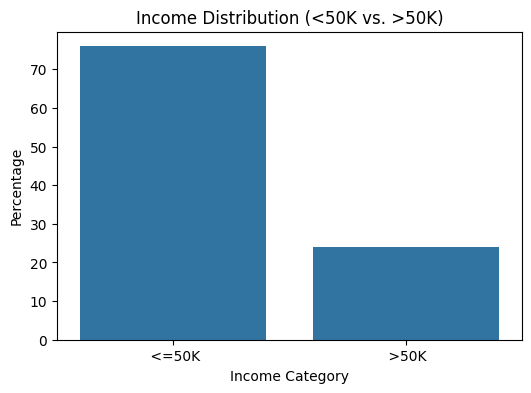

In [55]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.data', header=None, names = col_names)

print(df.head(3))

# Calculate the distribution of income categories
income_distribution = df['income'].value_counts(normalize=True) * 100

# Print the results
print("Income Distribution:")
print(income_distribution)

# Optionally, visualize the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=income_distribution.index, y=income_distribution.values)
plt.title("Income Distribution (<50K vs. >50K)")
plt.ylabel("Percentage")
plt.xlabel("Income Category")
plt.show()

In [56]:
# Remove leading and trailing spaces from all object (string) columns
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.str.strip())

# Verify that spaces have been removed
print("Columns with cleaned string data:")
print(df.head())


Columns with cleaned string data:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1       

In [57]:
# Select features from the DataFrame (excluding the target 'income')
feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

#Create feature dataframe X with feature columns and dummy variables for categorical features
X = pd.get_dummies(df[feature_cols], drop_first=True)

# Display the resulting features DataFrame
print("Features DataFrame (X):")
print(X.head())


Features DataFrame (X):
   age  capital-gain  capital-loss  hours-per-week  sex_Male  \
0   39          2174             0              40      True   
1   50             0             0              13      True   
2   38             0             0              40      True   
3   53             0             0              40      True   
4   28             0             0              40     False   

   race_Asian-Pac-Islander  race_Black  race_Other  race_White  
0                    False       False       False        True  
1                    False       False       False        True  
2                    False       False       False        True  
3                    False        True       False       False  
4                    False        True       False       False  


In [58]:
# Create the output variable y
y = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Display the first few values of y
print("Output variable (y):")
print(y.head())

# Calculate the distribution of the binary output variable
y_distribution = y.value_counts(normalize=True) * 100

# Print the results
print("Percentage Distribution of y:")
print(f"0 (<=50K): {y_distribution[0]:.2f}%")
print(f"1 (>50K): {y_distribution[1]:.2f}%")


Output variable (y):
0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64
Percentage Distribution of y:
0 (<=50K): 75.92%
1 (>50K): 24.08%


## Train-Test split

In [59]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)

## Random Forest Baseline

In [60]:
# Instantiate the RandomForestClassifier with default parameters
rf_classifier = RandomForestClassifier()

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Evaluate the model's accuracy on the test data
accuracy = rf_classifier.score(X_test, y_test)

# Print the accuracy
print(f"Baseline Accuracy of RandomForestClassifier: {accuracy:.2f}")

Baseline Accuracy of RandomForestClassifier: 0.82


## Random Forest Hyperparameter Tunning

In [61]:
# Initialize lists to store accuracy scores
np.random.seed(0)
accuracy_train = []
accuracy_test = []

# Define the range of depths
depths = range(1, 26)

# Test RandomForestClassifier performance over a range of max_depth values
for depth in depths:  # Loop through max_depth values from 1 to 25
    # Instantiate the model with the current max_depth
    rf_classifier = RandomForestClassifier(max_depth=depth)
    
    # Fit the model on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy = rf_classifier.score(X_train, y_train)
    accuracy_train.append(train_accuracy)
    
    # Compute accuracy on the test set
    test_accuracy = rf_classifier.score(X_test, y_test)
    accuracy_test.append(test_accuracy)

# Display the results
print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)


Training Accuracy: [0.7999846437346437, 0.800637285012285, 0.8100429975429976, 0.8175675675675675, 0.8180666461916462, 0.8200629606879607, 0.8205236486486487, 0.8226735257985258, 0.8244394963144963, 0.8261286855036855, 0.8324247542997543, 0.8366861179361179, 0.8392582923832924, 0.8420608108108109, 0.84432585995086, 0.8455927518427518, 0.8498541154791155, 0.8533476658476659, 0.8548065110565111, 0.8568412162162162, 0.8579929361179361, 0.858914312039312, 0.8597972972972973, 0.8603731572481572, 0.8606035012285013]
Testing Accuracy: [0.8105327805926609, 0.8109933978197451, 0.820205742361431, 0.8292645478274221, 0.8297251650545063, 0.8303393213572854, 0.8303393213572854, 0.8304928604329802, 0.831260555811454, 0.8301857822815907, 0.8323353293413174, 0.8346384154767388, 0.8340242591739597, 0.8320282511899278, 0.8324888684170121, 0.8335636419468755, 0.8306463995086749, 0.8265008444649163, 0.8255796100107478, 0.8255796100107478, 0.822201750345463, 0.8229694457239367, 0.822815906648242, 0.8206663

In [62]:
# Maximum accuracy and the depth at which it occurs
max_accuracy = max(accuracy_test)
optimal_depth = accuracy_test.index(max_accuracy) + 1  # +1 since depth starts at 1

# Display the results
print(f"The largest accuracy on the test data is {max_accuracy:.4f}, occurring at max_depth = {optimal_depth}.")


The largest accuracy on the test data is 0.8346, occurring at max_depth = 12.


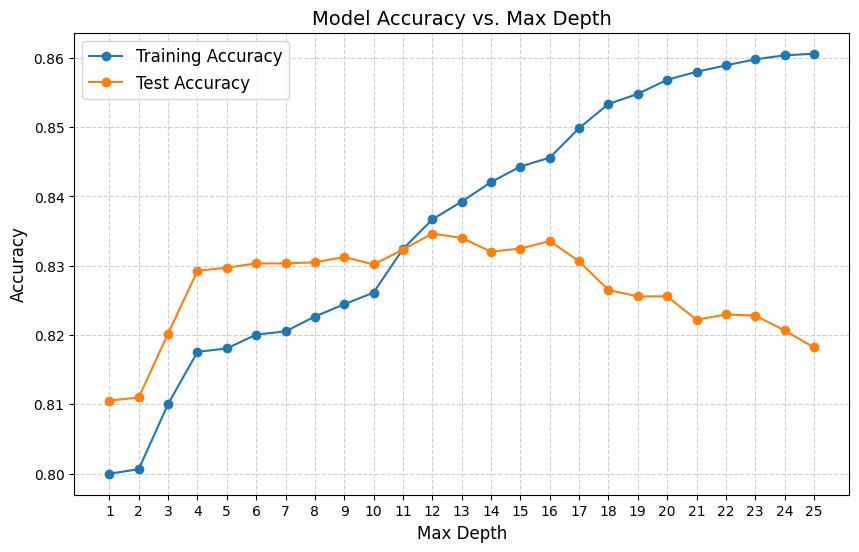

In [63]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracy_train, label="Training Accuracy", marker='o')
plt.plot(depths, accuracy_test, label="Test Accuracy", marker='o')

# Add labels, title, and legend
plt.title("Model Accuracy vs. Max Depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(depths)  # Ensure all depths are shown on the x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [64]:
plt.clf()

<Figure size 640x480 with 0 Axes>

## Model refit with optimal hyperparameters (depth)

In [65]:
# Random forest model refit using the optimal max_depth
optimal_rf = RandomForestClassifier(max_depth=optimal_depth)
optimal_rf.fit(X_train, y_train)

# Feature importances extraction
feature_importances = optimal_rf.feature_importances_

# Feature importances saving in a DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and display the top five features
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 5 Features:")
print(importance_df.head(5))

Top 5 Features:
          Feature  Importance
1    capital-gain    0.370119
0             age    0.248969
3  hours-per-week    0.140480
2    capital-loss    0.140439
4        sex_Male    0.078258


## Additional Features creation and model Re-Tuning

When looking at the `education` feature, it can be seen that there are 16 unique values, ranging from preschool to professional school. Instead of creating dummy variables for each value, it is more practical to group some of these values together. While there are multiple ways to approach this, one method is to combine them into three categories: **High school and less**, **College to Bachelors**, and **Masters and more**. A new column called `education_bin` can be created in `df` to represent this grouping.

In [66]:
# Define a mapping for education levels to bins
education_mapping = {
    'Preschool': 'High school and less',
    '1st-4th': 'High school and less',
    '5th-6th': 'High school and less',
    '7th-8th': 'High school and less',
    '9th': 'High school and less',
    '10th': 'High school and less',
    '11th': 'High school and less',
    '12th': 'High school and less',
    'HS-grad': 'High school and less',
    'Some-college': 'College to Bachelors',
    'Assoc-acdm': 'College to Bachelors',
    'Assoc-voc': 'College to Bachelors',
    'Bachelors': 'College to Bachelors',
    'Masters': 'Masters and more',
    'Prof-school': 'Masters and more',
    'Doctorate': 'Masters and more'
}

# Map the education feature to the new bins
df['education_bin'] = df['education'].map(education_mapping)

# Group by 'education_bin' and aggregate unique 'education' values, counts, and unique counts
education_summary = df.groupby('education_bin').agg({
    'education': [
        lambda x: sorted(x.unique()),  # List unique values
        lambda x: len(x.unique()),    # Count unique values
        'count'                       # Count total rows
    ]
}).rename(columns={
    '<lambda_0>': 'education',
    '<lambda_1>': 'unique_count',
    'count': 'total_count'
})

# Flatten the MultiIndex columns
education_summary.columns = education_summary.columns.droplevel(0)

# Display the summary
print(education_summary)


                                                              education  \
education_bin                                                             
College to Bachelors   [Assoc-acdm, Assoc-voc, Bachelors, Some-college]   
High school and less  [10th, 11th, 12th, 1st-4th, 5th-6th, 7th-8th, ...   
Masters and more                      [Doctorate, Masters, Prof-school]   

                      unique_count  total_count  
education_bin                                    
College to Bachelors             4        15095  
High school and less             9        14754  
Masters and more                 3         2712  


In [67]:
# Add the new feature 'education_bin' to the feature list
feature_cols_with_bin = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']

# Create a new features DataFrame, including 'education_bin'
X_new = df[feature_cols_with_bin]

# Convert categorical features to dummy variables, including the new feature
X_new = pd.get_dummies(X_new, drop_first=True)


## Tune of Model with new features

In [68]:
# Initialize new lists to store accuracy scores
accuracy_train_new = []
accuracy_test_new = []

X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=seed)


# Iterate over the range of max_depth values defined in 'depths'
for depth in depths:
    # Instantiate the model with the current max_depth
    rf_classifier_new = RandomForestClassifier(max_depth=depth, random_state=42)
    
    # Fit the model on the training data
    rf_classifier_new.fit(X_new_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy_new = rf_classifier_new.score(X_new_train, y_train)
    accuracy_train_new.append(train_accuracy_new)
    
    # Compute accuracy on the test set
    test_accuracy_new = rf_classifier_new.score(X_new_test, y_test)
    accuracy_test_new.append(test_accuracy_new)

# Display results for verification
print("New Training Accuracy:", accuracy_train_new)
print("New Testing Accuracy:", accuracy_test_new)


New Training Accuracy: [0.7640509828009828, 0.8027103808353808, 0.8154944717444718, 0.8205620393120393, 0.8305820024570024, 0.8339603808353808, 0.8352656633906634, 0.8366477272727273, 0.8382217444717445, 0.8453624078624079, 0.8485488329238329, 0.851159398034398, 0.8556511056511057, 0.8591062653562653, 0.8625614250614251, 0.8660549754299754, 0.8697404791154791, 0.8726965601965602, 0.8755374692874693, 0.878762285012285, 0.8807202088452089, 0.8830620393120393, 0.8840218058968059, 0.8855190417690417, 0.8862484643734644]
New Testing Accuracy: [0.7782895746967603, 0.8136035621065562, 0.8246583755565792, 0.8298787041302012, 0.8386304314448026, 0.8426224474128666, 0.8430830646399509, 0.8438507600184247, 0.844311377245509, 0.8479963150621833, 0.8476892369107938, 0.8493781667434362, 0.8486104713649624, 0.8498387839705205, 0.8498387839705205, 0.8487640104406572, 0.8486104713649624, 0.8473821587594043, 0.8475356978350991, 0.8444649163212038, 0.8432366037156457, 0.8415476738830032, 0.84001228312605

In [69]:
# Find the largest accuracy and corresponding depth for the new model
max_accuracy_new = max(accuracy_test_new)
optimal_depth_new = accuracy_test_new.index(max_accuracy_new) + 1  # Adjust for depth starting at 1

# Find the largest accuracy and corresponding depth for the previous model
max_accuracy_prev = max(accuracy_test)
optimal_depth_prev = accuracy_test.index(max_accuracy_prev) + 1  # Adjust for depth starting at 1

# Print the results for comparison
print(f"New Model: Largest accuracy on test data is {max_accuracy_new:.4f} at max_depth = {optimal_depth_new}.")
print(f"Previous Model: Largest accuracy on test data is {max_accuracy_prev:.4f} at max_depth = {optimal_depth_prev}.")

# Comparison
if max_accuracy_new > max_accuracy_prev:
    print("The new model with 'education_bin' outperforms the previous model.")
elif max_accuracy_new < max_accuracy_prev:
    print("The previous model outperforms the new model with 'education_bin'.")
else:
    print("Both models achieve the same accuracy.")


New Model: Largest accuracy on test data is 0.8498 at max_depth = 14.
Previous Model: Largest accuracy on test data is 0.8346 at max_depth = 12.
The new model with 'education_bin' outperforms the previous model.


### Visualisation of accuracy comparison: New Model vs Previous One:

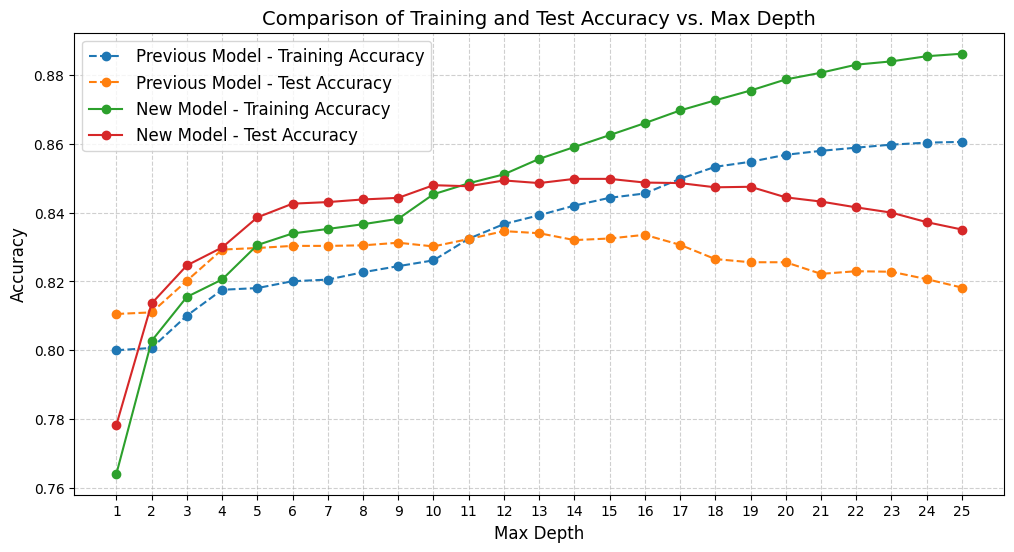

In [70]:
# Plot the training and test accuracy for the previous model
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracy_train, label="Previous Model - Training Accuracy", linestyle="--", marker='o')
plt.plot(depths, accuracy_test, label="Previous Model - Test Accuracy", linestyle="--", marker='o')

# Plot the training and test accuracy for the new model
plt.plot(depths, accuracy_train_new, label="New Model - Training Accuracy", linestyle="-", marker='o')
plt.plot(depths, accuracy_test_new, label="New Model - Test Accuracy", linestyle="-", marker='o')

# Add labels, title, and legend
plt.title("Comparison of Training and Test Accuracy vs. Max Depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(depths)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [71]:

# Refit the random forest model for the new model using the optimal max_depth
rf_classifier_new = RandomForestClassifier(max_depth=optimal_depth_new)
rf_classifier_new.fit(X_new_train, y_train)

# Extract feature importances for the new model
feature_importances_new = rf_classifier_new.feature_importances_

# Save the feature importances in a DataFrame for the new model
importance_df_new = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': feature_importances_new
}).sort_values(by='Importance', ascending=False)


# Print the top 5 features for the new model
print("Top 5 Features - New Model:")
print(importance_df_new.head(5))


# Comparison of top features
print("\nComparison of Top Features:")
print("New Model Features:", list(importance_df_new.head(5)['Feature']))
print("Previous Model Features:", list(importance_df.head(5)['Feature']))


Top 5 Features - New Model:
                           Feature  Importance
1                     capital-gain    0.286055
0                              age    0.227957
3                   hours-per-week    0.128783
2                     capital-loss    0.103361
10  education_bin_Masters and more    0.081172

Comparison of Top Features:
New Model Features: ['capital-gain', 'age', 'hours-per-week', 'capital-loss', 'education_bin_Masters and more']
Previous Model Features: ['capital-gain', 'age', 'hours-per-week', 'capital-loss', 'sex_Male']


### Final Note

This project could be extended by considering hyperparameter tuning based on a different evaluation metric. Since the target variable classes are fairly imbalanced, using metrics such as **AUC** or **F1 score** instead of accuracy may lead to different results. This approach could help optimize the model for better performance on imbalanced 
